# Experimentos GFS: Análisis de Rendimiento RAG

Este cuaderno realiza experimentos sistemáticos con Google Generative File Search.

**Objetivos**:
1. Definir conjunto de consultas de prueba
2. Medir latencia de respuesta (P50, P95, P99)
3. Analizar calidad de recuperación
4. Examinar fundamentación/citas
5. Calcular costos

In [1]:
%matplotlib inline

import sys
from pathlib import Path
import json
import time
from typing import List, Dict

project_root = Path.cwd().parent
sys.path.append(str(project_root / "src"))

from gfs_client import GFSClient
from utils import load_api_key

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

print("Imports successful")

Imports successful


## 1. Cargar Almacén e Inicializar Cliente

In [2]:
# Load API key
api_key = load_api_key("GOOGLE_API_KEY", str(project_root / ".env"))
gfs = GFSClient(api_key=api_key)

# Load store metadata
metadata_path = project_root / "models" / "gfs_stores" / "metadata.json"
with open(metadata_path, "r") as f:
    store_metadata = json.load(f)

store_name = store_metadata["store_name"]
print(f"Using store: {store_metadata['display_name']}")
print(f"Store name: {store_name}")

Using store: RAG Comparison Document Store
Store name: fileSearchStores/rag-comparison-document-sto-bl56voi03s98


## 2. Definir Consultas de Prueba

Crear un conjunto diverso de consultas que cubra diferentes patrones:
- Búsquedas factuales
- Preguntas analíticas
- Razonamiento multi-documento
- Casos extremos (fuera de dominio)

In [3]:
# Test query set
test_queries = [
    {
        "id": "q1",
        "query": "What are the main topics covered in the documents?",
        "category": "overview"
    },
    {
        "id": "q2",
        "query": "Summarize the key findings or conclusions.",
        "category": "synthesis"
    },
    {
        "id": "q3",
        "query": "What specific data or statistics are mentioned?",
        "category": "factual"
    },
    {
        "id": "q4",
        "query": "Are there any recommendations or best practices?",
        "category": "actionable"
    },
    {
        "id": "q5",
        "query": "What is the weather forecast for tomorrow?",
        "category": "out_of_domain"
    },
]

print(f"Test queries: {len(test_queries)}")

Test queries: 5


## 3. Ejecutar Experimentos

In [4]:
# Run queries and collect metrics
results = []

for i, test in enumerate(test_queries):
    print(f"\n[{i+1}/{len(test_queries)}] {test['id']}: {test['query'][:50]}...")
    
    try:
        start_time = time.time()
        
        response = gfs.query_with_file_search(
            query=test["query"],
            store_names=[store_name],
            temperature=0.0
        )
        
        latency = time.time() - start_time
        
        # Extract citations
        citations = gfs.extract_citations(response)
        has_citations = citations is not None and citations.get("search_entry_point") is not None
        
        # Count tokens (rough estimate)
        response_text = response.text
        token_count = len(response_text.split()) * 1.3  # Rough approximation
        
        result = {
            "query_id": test["id"],
            "category": test["category"],
            "latency_seconds": latency,
            "response_length": len(response_text),
            "estimated_tokens": int(token_count),
            "has_citations": has_citations,
            "status": "success"
        }
        
        print(f"  ✓ Latency: {latency:.2f}s, Citations: {has_citations}")
        
    except Exception as e:
        result = {
            "query_id": test["id"],
            "category": test["category"],
            "status": "failed",
            "error": str(e)
        }
        print(f"  ✗ Failed: {e}")
    
    results.append(result)
    
    # Rate limiting
    time.sleep(1)

print(f"\nExperiments completed: {len(results)} queries")


[1/5] q1: What are the main topics covered in the documents?...
  ✓ Latency: 7.19s, Citations: False

[2/5] q2: Summarize the key findings or conclusions....
  ✓ Latency: 3.80s, Citations: False

[3/5] q3: What specific data or statistics are mentioned?...
  ✓ Latency: 4.28s, Citations: False

[4/5] q4: Are there any recommendations or best practices?...
  ✓ Latency: 7.08s, Citations: False

[5/5] q5: What is the weather forecast for tomorrow?...
  ✓ Latency: 2.40s, Citations: False

Experiments completed: 5 queries


## 4. Analizar Rendimiento

In [5]:
# Calculate latency statistics
successful_results = [r for r in results if r["status"] == "success"]

if successful_results:
    latencies = [r["latency_seconds"] for r in successful_results]
    
    print("Latency Statistics:")
    print(f"  Mean: {np.mean(latencies):.3f}s")
    print(f"  Median (P50): {np.median(latencies):.3f}s")
    print(f"  P95: {np.percentile(latencies, 95):.3f}s")
    print(f"  P99: {np.percentile(latencies, 99):.3f}s")
    print(f"  Min: {np.min(latencies):.3f}s")
    print(f"  Max: {np.max(latencies):.3f}s")
    
    # Citation rate
    citation_rate = sum(r["has_citations"] for r in successful_results) / len(successful_results)
    print(f"\nCitation Rate: {citation_rate*100:.1f}%")
else:
    print("No successful queries to analyze")

Latency Statistics:
  Mean: 4.951s
  Median (P50): 4.281s
  P95: 7.168s
  P99: 7.186s
  Min: 2.403s
  Max: 7.191s

Citation Rate: 0.0%


/var/folders/p1/vpgfln0n1_z645h_60n7_9940000gr/T/ipykernel_83047/3249420697.py:20: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax2.boxplot(cat_latencies, labels=unique_cats)


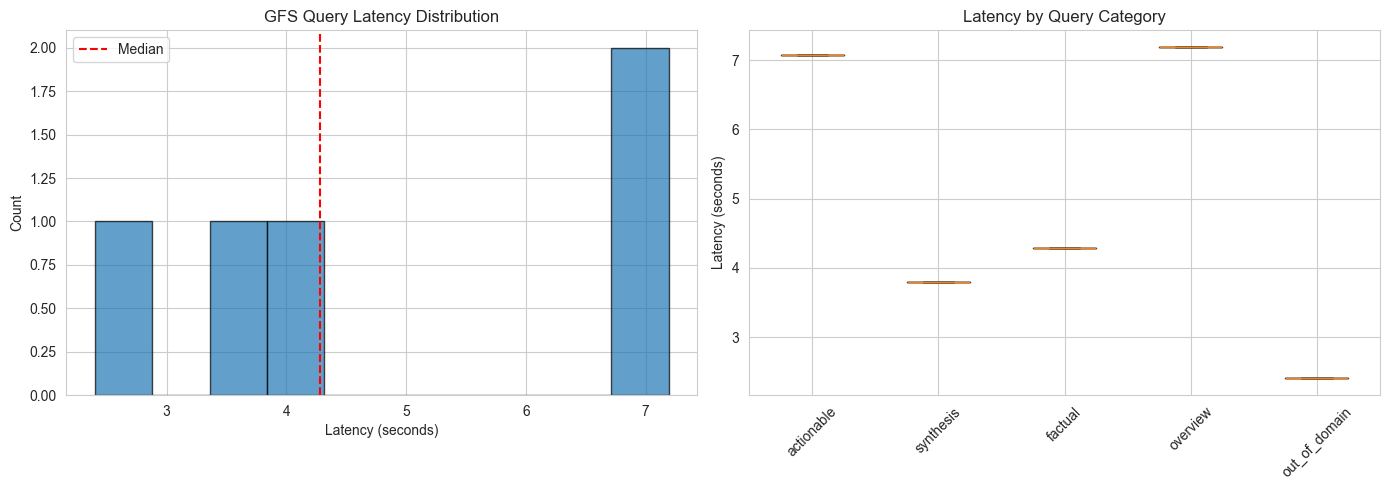

In [6]:
# Visualize latency distribution
if successful_results:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Histogram
    ax1.hist(latencies, bins=10, edgecolor="black", alpha=0.7)
    ax1.axvline(np.median(latencies), color="red", linestyle="--", label="Median")
    ax1.set_xlabel("Latency (seconds)")
    ax1.set_ylabel("Count")
    ax1.set_title("GFS Query Latency Distribution")
    ax1.legend()
    
    # Box plot by category
    categories = [r["category"] for r in successful_results]
    unique_cats = list(set(categories))
    
    cat_latencies = [[r["latency_seconds"] for r in successful_results if r["category"] == cat] 
                     for cat in unique_cats]
    
    ax2.boxplot(cat_latencies, labels=unique_cats)
    ax2.set_ylabel("Latency (seconds)")
    ax2.set_title("Latency by Query Category")
    ax2.tick_params(axis="x", rotation=45)
    
    plt.tight_layout()
    plt.show()

## 5. Análisis de Costos

In [7]:
# Estimate query costs
if successful_results:
    total_tokens = sum(r["estimated_tokens"] for r in successful_results)
    
    # Gemini pricing (example rates)
    # Input: retrieved context counted as input tokens
    # Output: generated response tokens
    # Using approximate rate: $0.075 per 1M input tokens, $0.30 per 1M output tokens
    
    estimated_cost_per_query = (total_tokens / 1_000_000) * 0.30 / len(successful_results)
    
    print("Cost Estimation:")
    print(f"  Total estimated tokens: {total_tokens:,}")
    print(f"  Avg tokens per query: {total_tokens / len(successful_results):.0f}")
    print(f"  Estimated cost per query: ${estimated_cost_per_query:.6f}")
    print(f"  Estimated cost for 1000 queries: ${estimated_cost_per_query * 1000:.2f}")
    print("\nNote: This is a rough estimate. Actual costs depend on retrieved context size.")

Cost Estimation:
  Total estimated tokens: 1,420
  Avg tokens per query: 284
  Estimated cost per query: $0.000085
  Estimated cost for 1000 queries: $0.09

Note: This is a rough estimate. Actual costs depend on retrieved context size.


## 6. Guardar Resultados

In [8]:
# Save experimental results
results_path = project_root / "models" / "gfs_stores" / "experiment_results.json"

output = {
    "store_name": store_name,
    "model_id": gfs.model_id,
    "queries": test_queries,
    "results": results,
    "summary": {
        "total_queries": len(results),
        "successful": len(successful_results),
        "failed": len(results) - len(successful_results),
        "mean_latency": np.mean(latencies) if successful_results else None,
        "median_latency": np.median(latencies) if successful_results else None,
        "citation_rate": citation_rate if successful_results else None,
    }
}

with open(results_path, "w") as f:
    json.dump(output, f, indent=2)

print(f"Results saved to: {results_path}")

Results saved to: /Users/ggoni/docencia-repos/rag-with-gfs/models/gfs_stores/experiment_results.json


## Resumen

**Métricas de Rendimiento GFS Recopiladas**:
- Latencia de consulta (P50, P95, P99)
- Tasa de citación/fundamentación
- Estimaciones de uso de tokens
- Proyecciones de costos

**Próximos Pasos**:
- Implementar línea base de RAG personalizado en `04_custom_rag_baseline.ipynb`
- Ejecutar el mismo conjunto de consultas en RAG personalizado
- Comparar métricas en `05_comparison_analysis.ipynb`